# Facial Emotion Recogination

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator, load_img
import cv2
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils import plot_model

## Import data

In [4]:
train_data_dir = '../FER-Capstone/data/train/'
test_data_dir = '../FER-Capstone/data/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_data_count = count_exp(train_data_dir, 'train data')
test_data_count = count_exp(test_data_dir, 'test data')
print(train_data_count)
print(test_data_count)

            happy   sad  fear  surprise  neutral  angry  disgust
train data   7215  4830  4097      3171     4965   3995      436
           happy   sad  fear  surprise  neutral  angry  disgust
test data   1774  1247  1024       831     1233    958      111


### Bar chart for emotion images in train data

<AxesSubplot:>

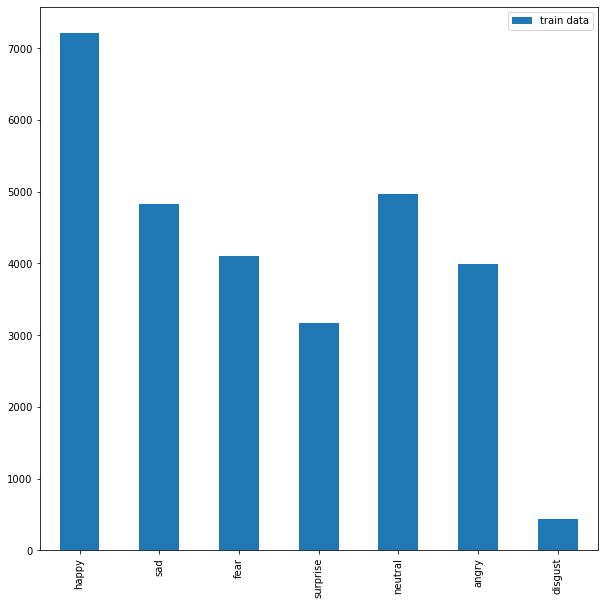

In [5]:
train_data_count.transpose().plot(kind='bar', figsize=(10,10))

### Bar chart for emotion images in test data

<AxesSubplot:>

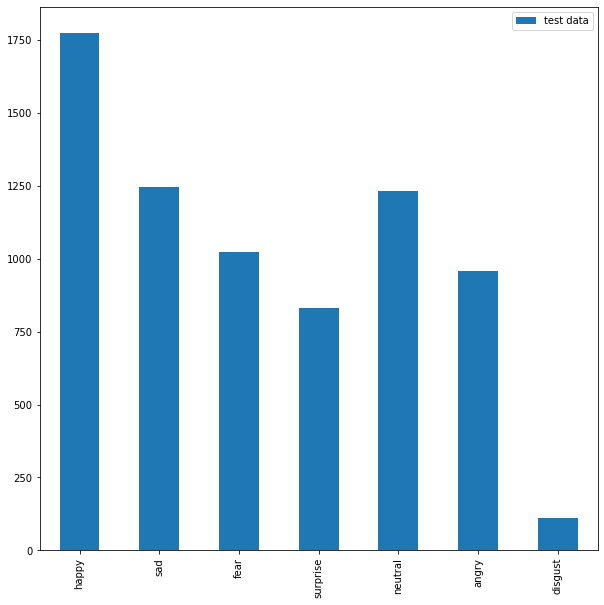

In [6]:
test_data_count.transpose().plot(kind='bar', figsize=(10,10))

### Examples of emotion images in dataset

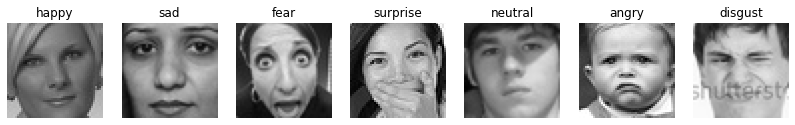

In [7]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_data_dir):
    img = load_img((train_data_dir + expression +'/'+ os.listdir(train_data_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Create Training and test datasets

In [8]:
train_data_generator = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_data_generator.flow_from_directory(train_data_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_data_generator = ImageDataGenerator(rescale=1./255)
test_set = test_data_generator.flow_from_directory(test_data_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Constructure Model

In [24]:
model = Sequential()   

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

c:\Users\Grace\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Training Model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size
hist = model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

## Loss and Accuracy plot

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can se seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

### Model evaluation

In [ ]:
train_loss, train_accu = model.evaluate(training_set) #Evaluates train data for accuracy and loss 
test_loss, test_accu = model.evaluate(test_set) #Evaluates test data for accuracy and loss 
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

### Serialize the model to JSON and save the model weights

In [ ]:
model_json = model.to_json()
with open("model_structure.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weights.h5")

### Import model weight and haar cascade file

In [ ]:
from keras.models import model_from_json
from PIL import Image
model = model_from_json(open("model_structure.json", "r").read())
model.load_weights('model_weights.h5')
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')